# Топологический анализ изображений

In [1]:
!pip install gudhi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 27.6 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
from torch.nn.functional import relu, softmax
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import transforms
from torchvision.datasets import MNIST

from torch.optim import Adam
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

import numpy as np

from gudhi.sklearn.cubical_persistence import CubicalPersistence

import matplotlib.pyplot as plt
from PIL import Image

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [5]:
class Orbit2kDataset(Dataset):
    def __init__(self, X, y, transform=transform):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [6]:
class MLP(nn.Module):
    def __init__(self, d_in, d_hidden, d_out):
        super().__init__()
        self.linear1 = nn.Linear(d_in, d_hidden)
        self.linear2 = nn.Linear(d_hidden, d_out)

    def forward(self, x):
        x = relu(self.linear1(x))
        x = self.linear2(x)
        return x

## MLP на сверточных фильтрах

#### Model

In [ ]:
torch.manual_seed(0)

In [33]:
class FeatureExtractor(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_channels, kernel_size=(3,3))  
        self.conv2 = nn.Conv2d(in_channels=n_channels, out_channels=n_channels, groups=4, kernel_size=(3,3))  
        self.conv3 = nn.Conv2d(in_channels=n_channels, out_channels=n_channels, groups=2, kernel_size=(3,3))  
        self.bn3 = nn.BatchNorm2d(num_features=n_channels)

    def forward(self, X):
        X = relu(self.conv1(X))
        X = self.conv2(X)
        X = self.bn3(self.conv3(X))
        return X

#### Dataset

In [ ]:
X_mnist, y_mnist = fetch_openml("mnist_784", return_X_y=True, as_frame=False)

In [9]:
# получаем свертки
start = 0
take_n = 70000
n_channels = 8

X = torch.tensor(X_mnist[start:start+take_n].reshape((take_n, 1, 28, 28)), dtype=torch.float)
feature_extractor = FeatureExtractor(n_channels)
Y = feature_extractor(X).detach().numpy()

In [10]:
# создаем датасет
X_mnist_features = Y.reshape(Y.shape[0], -1)
y_mnist = y_mnist.astype(np.int64)

n_train, n_test = 60000, 10000

dataset_mlp = Orbit2kDataset(X_mnist_features, y_mnist)
dataset_train_mlp, dataset_test_mlp = train_test_split(dataset_mlp, train_size=n_train, test_size=n_test, shuffle=False)

#### Train

In [ ]:
%%time
n_repeats = 1
n_epochs = 100

history_mlp = np.zeros((n_repeats, n_epochs, 3))
criterion = nn.CrossEntropyLoss()

for repeat_idx in range(n_repeats):
    lr = 0.001
    mlp = MLP(8 * 22 * 22, 256, 10)
    optimizer = torch.optim.SGD(mlp.parameters(), lr=lr)

    print("{:3} {:6} {:6} {:6}".format(repeat_idx, "Loss", "Train", "Test"))

    dataloader_train_mlp = DataLoader(dataset_train_mlp, batch_size=64, shuffle=True)
    dataloader_test_mlp = DataLoader(dataset_test_mlp, batch_size=64, shuffle=True)

    for epoch_idx in range(n_epochs):
        # train
        mlp.train()

        loss_epoch = []
        for i, data in enumerate(dataloader_train_mlp, 0):
            x, y = data
            optimizer.zero_grad()
            y_pred = mlp(x.reshape(x.shape[0], -1))
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            loss_epoch.append(loss.detach())

        loss_epoch_mean = np.array(loss_epoch).mean()
        history_mlp[repeat_idx,epoch_idx,0] = loss_epoch_mean

        # test
        mlp.eval()

        correct = 0
        total = 0

        with torch.no_grad():
            for data in dataloader_train_mlp:
                x, y = data
                y_pred = mlp(x)
                predicted = torch.argmax(y_pred, dim=1)
                total += y.size(0)
                correct += (predicted == y).sum().item()

        accuracy_train = 100 * correct / total
        history_mlp[repeat_idx,epoch_idx,1] = accuracy_train

        correct = 0
        total = 0

        with torch.no_grad():
            for data in dataloader_test_mlp:
                x, y = data
                y_pred = mlp(x)
                predicted = torch.argmax(y_pred, dim=1)
                total += y.size(0)
                correct += (predicted == y).sum().item()

        accuracy_test = 100 * correct / total
        history_mlp[repeat_idx,epoch_idx,2] = accuracy_test

        print("{:3} {:.4f} {:.4f} {:.4f}".format(epoch_idx, loss_epoch_mean, accuracy_train, accuracy_test))
    print("\r")

## Топологические признаки

In [14]:
def conv_pd(diagrams):
    pd = np.zeros((0, 3))

    for k, diagram_k in enumerate(diagrams):
        diagram_k = np.concatenate((diagram_k, k * np.ones((diagram_k.shape[0], 1))), axis=1)
        pd = np.concatenate((pd, diagram_k))

    return pd

In [16]:
persistence = CubicalPersistence(homology_dimensions=[0, 1])

D = []

for i in range(70000):
    D.append(persistence.fit_transform(Y[i]))

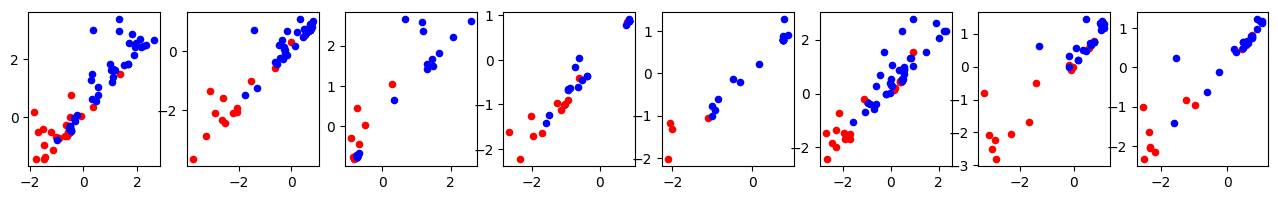

In [21]:
pds = persistence.fit_transform(Y[5])

fig, ax = plt.subplots(ncols=8, figsize=(16,2))

for i in range(8):
   ax[i].scatter(pds[i][0][:,0], pds[i][0][:,1], c="r", s=20)
   ax[i].scatter(pds[i][1][:,0], pds[i][1][:,1], c="b", s=20)

### Конкатенация диаграмм устойчивости

In [22]:
def conv_d_for_filters(D, max_value):
    n_batch = len(D)
    n_filters = len(D[0])

    D_new = []

    for i in range(n_batch):
        D_one_layer = []
        for j in range(n_filters):
            D[i][j][0] = np.nan_to_num(D[i][j][0], posinf=max_value)
            D[i][j][1] = np.nan_to_num(D[i][j][1], posinf=max_value)
            layer = D[i][j]
            D_one_layer.append(conv_pd(layer))
        D_new.append(D_one_layer)

    return D_new

def conv_filters(D):
    n_images = len(D)
    n_filters = len(D[0])

    result = []

    for i in range(n_images):
        result_for_image = []
        for j in range(n_filters):
            layer = D[i][j] # shape (x, 3)

            filter_array = np.zeros((layer.shape[0], 8))
            filter_array[:, j] = 1

            # конкантенирование горизонтально
            combined_array = np.concatenate((layer, filter_array), axis=1)

            # конкантенирование вертикально
            if len(result_for_image) == 0:
                result_for_image = combined_array
            else:
                result_for_image = np.concatenate((result_for_image, combined_array), axis=0)

        result.append(result_for_image)

    return result

In [23]:
max_value = np.max(Y)
D_result = conv_d_for_filters(D, max_value)
conv_D = conv_filters(D_result)

## DeepSets на диаграммах устойчивости

#### Model

In [25]:
class DeepSets(torch.nn.Module):
    def __init__(self, n_in, n_hidden_enc, n_out_enc, n_hidden_dec=16, n_out_dec=2):
        super(DeepSets, self).__init__()
        self.encoder = MLP(n_in, n_hidden_enc, n_out_enc)
        self.decoder = MLP(n_out_enc, n_hidden_dec, n_out_dec)
        
    def forward(self, X):
        X = self.encoder(X)
        x = X.mean(dim=1)
        x = self.decoder(x)
        return x

def collate_fn(data):
    tmp_pd, _ = data[0]
    
    n_batch = len(data)
    n_features_pd = tmp_pd.shape[1]
    n_points_pd = max(len(pd) for pd, _ in data)
    inputs_pd = np.zeros((n_batch, n_points_pd, n_features_pd), dtype=float)
    labels = np.zeros(len(data))
    
    for i, (pd, label) in enumerate(data):
        inputs_pd[i][:len(pd)] = pd
        labels[i] = label
    
    return torch.Tensor(inputs_pd), torch.Tensor(labels).long()

####Dataset

In [26]:
n_train, n_test = 60000, 10000
dataset_deepsets = Orbit2kDataset(conv_D, y_mnist)
dataset_train_deepsets, dataset_test_deepsets = train_test_split(dataset_deepsets, train_size=n_train, test_size=n_test, shuffle=False)

#### Train

In [ ]:
%%time
n_repeats = 5
n_epochs = 100
batch_size = 64

history_deep_sets = np.zeros((n_repeats, n_epochs, 3))
criterion = nn.CrossEntropyLoss()

for repeat_idx in range(n_repeats):
    lr = 0.001
    deepsets = DeepSets(n_in=3+8, n_hidden_enc=64, n_out_enc=32, n_hidden_dec=16, n_out_dec=10)
    optimizer = Adam(deepsets.parameters(), lr=lr)

    dataloader_train_deepsets = DataLoader(dataset_train_deepsets, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    dataloader_test_deepsets = DataLoader(dataset_test_deepsets, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    print("{:3} {:6} {:6} {:6}".format(repeat_idx, "Loss", "Train", "Test"))

    for epoch_idx in range(n_epochs):
        #train
        deepsets.train()

        loss_epoch = []
        for i, data in enumerate(dataloader_train_deepsets, 0):
            x, y = data
            optimizer.zero_grad()
            y_pred = deepsets(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            loss_epoch.append(loss.detach())

        loss_epoch_mean = np.array(loss_epoch).mean()
        history_deep_sets[repeat_idx,epoch_idx,0] = loss_epoch_mean

        #test
        deepsets.eval()

        correct = 0
        total = 0

        with torch.no_grad():
            for data in dataloader_train_deepsets:
                x, y = data
                y_pred = deepsets(x)
                predicted = torch.argmax(y_pred, dim=1)
                total += y.size(0)
                correct += (predicted == y).sum().item()

        accuracy_train = 100 * correct / total
        history_deep_sets[repeat_idx,epoch_idx,1] = accuracy_train

        correct = 0
        total = 0

        with torch.no_grad():
            for data in dataloader_test_deepsets:
                x, y = data
                y_pred = deepsets(x)
                predicted = torch.argmax(y_pred, dim=1)
                total += y.size(0)
                correct += (predicted == y).sum().item()

        accuracy_test = 100 * correct / total
        history_deep_sets[repeat_idx,epoch_idx,2] = accuracy_test

        print("{:3} {:.4f} {:.4f} {:.4f}".format(epoch_idx, loss_epoch_mean, accuracy_train, accuracy_test))
    print("\r")

##Blending

In [30]:
dataloader_test_mlp = DataLoader(dataset_test_mlp, batch_size=64, shuffle=False)
dataloader_test_deepsets = DataLoader(dataset_test_deepsets, batch_size=64, shuffle=False, collate_fn=collate_fn)

In [ ]:
blending_weights = [0.5, 0.5]

correct = 0
total = 0

with torch.no_grad():
    for data1, data2 in zip(dataloader_test_deepsets, dataloader_test_mlp):
        x1, y1 = data1
        x2, y2 = data2
        
        y_pred1 = deepsets(x1)
        y_pred2 = mlp(x2)
        y_pred = blending_weights[0] * y_pred1 + blending_weights[1] * y_pred2
        predicted = torch.argmax(y_pred, dim=1)

        total += y2.size(0)
        correct += (predicted == y2).sum().item()

accuracy = 100 * correct / total

print('Accuracy of the blended models on the test images: {:.2f}%'.format(accuracy))

###Поворот картинок

In [ ]:
X_raw, y = fetch_openml("mnist_784", return_X_y=True, as_frame=False)

In [26]:
images = [Image.fromarray(x.reshape(28, 28)) for x in X_raw]
rotated_images = [img.rotate(90) for img in images]
X_mnist_rotated = [np.array(img).reshape(784,) for img in rotated_images]
X_mnist_rotated = np.array(X_mnist_rotated)

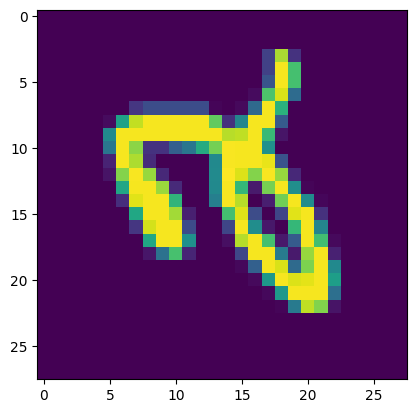

In [27]:
plt.imshow(X_mnist_rotated[5].reshape((28, 28)))

In [34]:
# получаем свертки
start = 0
take_n = 70000
n_channels = 8

X_rotated = torch.tensor(X_mnist_rotated.reshape((take_n, 1, 28, 28)), dtype=torch.float)
feature_extractor = FeatureExtractor(n_channels)
Y_rotated = feature_extractor(X_rotated).detach().numpy()

In [35]:
# создаем датасет
X_mnist_features = Y_rotated.reshape(Y_rotated.shape[0], -1)
y_mnist_features = y_mnist.astype(np.int64)

n_train, n_test = 60000, 10000

dataset_mlp_rotated = Orbit2kDataset(X_mnist_features, y_mnist_features)
dataset_train_mlp_rotated, dataset_test_mlp_rotated = train_test_split(dataset_mlp_rotated, train_size=n_train, test_size=n_test, shuffle=False)

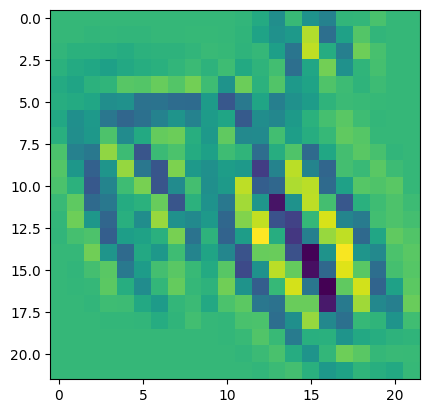

In [37]:
plt.imshow(dataset_train_mlp_rotated[5][0].reshape((8, 22, 22))[6])

###Тестирование mlp на повернутых изображениях

In [38]:
dataloader_test_rotated_mlp = DataLoader(dataset_test_mlp_rotated, batch_size=64, shuffle=True)

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in dataloader_test_rotated_mlp:
        x, y = data
        y_pred = mlp(x)
        predicted = torch.argmax(y_pred, dim=1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

accuracy = 100 * correct / total

print('Accuracy of the mlp on the rotated test images: {:.2f}%'.format(accuracy))

###Тестирование deepsets на повернутых изображениях

#### Dataset 

In [36]:
persistence = CubicalPersistence(homology_dimensions=[0, 1])

D_rotated = []

for i in range(70000):
    D_rotated.append(persistence.fit_transform(Y_rotated[i]))

D_result_rotated = conv_d_for_filters(D_rotated, max_value)
conv_D_rotated = conv_filters(D_result_rotated)

In [ ]:
n_train, n_test = 60000, 10000
dataset_deepsets_rotated = Orbit2kDataset(conv_D_rotated, y_mnist)
dataset_train_deepsets_rotated, dataset_test_deepsets_rotated = train_test_split(dataset_deepsets_rotated, train_size=n_train, test_size=n_test, shuffle=False)

In [ ]:
dataloader_test_rotated_deepsets = DataLoader(dataset_test_deepsets_rotated, batch_size=64, shuffle=True)

####Test

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in dataloader_test_rotated_deepsets:
        x, y = data
        y_pred = deepsets(x)
        predicted = torch.argmax(y_pred, dim=1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

accuracy = 100 * correct / total

print('Accuracy of the deepsets on the rotated test images: {:.2f}%'.format(accuracy))